# Iconic Technical Assignment

Author: Mustafa Hussain Kathawala
Date: 25th April 2021

## Executive Summary

### Problem Statement
In order to provide a personalized user experience, knowing the gender of the customer is essential. However, many customers do not provide such information while shoping on Iconic's platform. It is therefore necessary to develop a robust way to guess the gender of customers indirectly from their shopping choices and behavior.

### Proposed Solution
We first delve into cleaning up the data and understanding what each column really means. Further we also try to curate new features by combining or transforming existing ones. The next step is to carve out a subset of the data which has certain traits that can definitively classify the customer into a particular gender. This rule based initial approach gives us an opportunity to label a subset of the dataset. An ML model is trained using this and then predictions are generated on the unlablled dataset as well. For the customers that the model can classify with very high confidence, we assume to be correct and therefore label them as well to add it to the original labelled dataset. While this can go on iteratively, we stop here and train our final model on this data.

### Value
This is a simple solution which combines domain knowledge and machine learning. The baseline is set using rules and then built upon using ML models which can learn more subtle decision boundaries between the two gender classes. Even after just two steps we were able to label >80% of the data and train the model.

### Final Thoughts
It is imperative to validate this approach on actual labelled data. In addition more information such as browsing history, etc. will enhance the accuracy of this appraoch significantly.

# Let's Begin!

## Import the necessary libraries

In [ ]:
# Optional
# !pip install -r requirements.txt

In [2]:
import numpy as np
import pandas as pd
pd.options.display.max_rows = None
pd.options.display.max_columns = None

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

import hashlib
import sqlite3

# Retrieve the Data and Database

In [3]:
m = hashlib.sha256(b'welcometotheiconic')
pwd = m.hexdigest()

print(f"The unserialized password for the test files is '{pwd}'")

The unserialized password for the test files is '186e48fa1aafbaf63c1c295e560c2a5e0bf241e9cae0a59038e27aa8225d8c63'


Let's unzip the files using the password

In [4]:
!unzip -P $pwd -o test_data.zip
!unzip -P $pwd -o test_data.db.zip

Archive:  test_data.zip
  inflating: data.json               
Archive:  test_data.db.zip
  inflating: test_data.db            


Connect to the `sqlite` database and extract the tables present

In [5]:
connection = sqlite3.connect('test_data.db')
cursor = connection.cursor()

# utility function to execute and fetch sql statement
def run_query(query : str) -> str:
    cursor.execute(query)
    
    return cursor.fetchall()

# utility function to execute query and return as a pandas dataframe
def panda_query(query : str) -> pd.DataFrame:
    return pd.read_sql(query, connection)

# Check to see which tables are present in the database
print(run_query("SELECT name FROM sqlite_master WHERE type='table';")[0])

('customers',)


# Data Cleaning

Let's take a look at the first few rows

In [6]:
data = pd.read_sql("SELECT * FROM customers;", connection)
print(data.shape)
data.head(10)

(46279, 43)


,customer_id,days_since_first_order,days_since_last_order,is_newsletter_subscriber,orders,items,cancels,returns,different_addresses,shipping_addresses,devices,vouchers,cc_payments,paypal_payments,afterpay_payments,apple_payments,female_items,male_items,unisex_items,wapp_items,wftw_items,mapp_items,wacc_items,macc_items,mftw_items,wspt_items,mspt_items,curvy_items,sacc_items,msite_orders,desktop_orders,android_orders,ios_orders,other_device_orders,work_orders,home_orders,parcelpoint_orders,other_collection_orders,redpen_discount_used,coupon_discount_applied,average_discount_onoffer,average_discount_used,revenue
0,64f7d7dd7a59bba7168cc9c960a5c60e,2091,15672,N,17,50,0,1,0,4,1,3,1,0,0,0,46,2,2,35,7,2,1,1,0,4,0,0,0,0,17,0,0,0,0,1,0,16,4554.39,248.65,0.3364,3584.4818,6946.34
1,fa7c64efd5c037ff2abcce571f9c1712,2082,528,Y,13,26,0,5,0,4,2,0,0,1,0,0,24,0,2,16,2,0,4,4,0,3,0,0,0,12,1,0,0,0,0,9,0,4,629.03,0.00,0.1404,1404.0966,5329.28
2,18923c9361f27583d2320951435e4888,2072,144,Y,71,152,2,2,1,6,2,3,1,0,1,0,147,3,2,96,33,2,17,17,0,3,0,0,0,10,61,0,0,0,0,11,0,60,6269.71,107.92,0.1851,1899.7270,14133.87
3,aa21f31def4edbdcead818afcdfc4d32,2054,49200,Y,2,2,0,0,0,1,1,1,1,0,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,2,0.00,90.90,0.0000,3875.6715,143.64
4,668c6aac52ff54d4828ad379cdb38e7d,2053,49272,Y,1,1,0,0,0,1,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0.00,0.00,0.0000,0.0000,0.00
5,5f1e0812c41be939d971e34236d4de5b,2044,49056,N,1,1,0,0,0,1,1,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0.00,0.00,0.0000,0.0000,63.59
6,d99c815802828fff123971010c99b55b,2042,49008,N,1,1,0,0,0,1,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,94.59,0.00,0.6983,6983.3887,40.86
7,7dae973c589d913f4ca4dacbd37feedf,2041,28920,N,2,2,0,0,0,2,1,1,1,0,0,0,1,0,1,1,0,1,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,2,85.45,18.18,0.2052,2488.9519,186.32
8,10bc5715ecec307441b3b4f378e58592,2030,8736,N,8,12,0,1,0,2,2,1,1,0,0,0,11,0,1,6,3,0,3,3,0,0,0,0,0,4,4,0,0,0,0,3,0,5,251.58,54.50,0.2207,2706.6216,774.03
9,111d48b932dae281aff64cae2f17c4d6,2034,48816,Y,1,1,1,0,0,1,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0.00,0.00,0.0000,0.0000,0.00


* Isn't Iconic ~10 years old? Yet `days_since_last_order` of some customers suggest they ordered something 100+ years ago! E.g. customer: `aa21f31def4edbdcead818afcdfc4d32`'s last order was 49200 days ago!
* Interestingly `days_since_last_order` is greater than `days_since_first_order` - this looks a bit fishy

#### Let's plot out `days_since_last_order` vs `days_since_first_order`

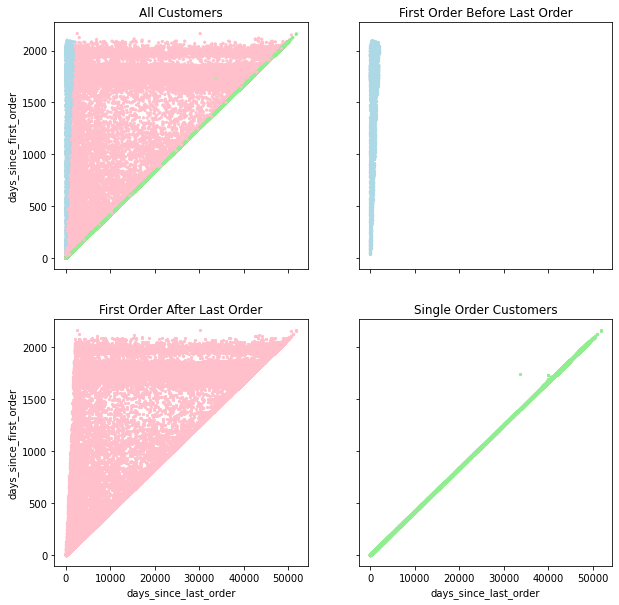

In [7]:
fig, axes = plt.subplots(
    nrows=2, ncols=2,
    figsize=(10, 10),
    sharey=True,
    sharex=True
)
single_order_color = 'lightgreen'
first_order_after_color = 'pink'
first_order_before_color = 'lightblue'

first_order_after = [True if x>y else False for x, y in zip(data['days_since_last_order'], data['days_since_first_order'])]
single_order = [True if x == 1 else False for x in data['orders']]
colors = [single_order_color if x else first_order_after_color if y else first_order_before_color for x, y in zip(single_order, first_order_after)]

# Plot all the points
data.plot.scatter(
    x='days_since_last_order',
    y='days_since_first_order',
    c=colors,
    marker='.',
    title='All Customers',
    ax=axes[0,0]
)

# Plot single order customers only
single_order = data[data.orders==1]
single_order.plot.scatter(
    x='days_since_last_order',
    y='days_since_first_order',
    marker='.',
    title="Single Order Customers",
    c=single_order_color,
    ax=axes[1,1])

# Plot customers with last order before first order
first_order_after = data[data['days_since_last_order'] > data['days_since_first_order']]
first_order_after.plot.scatter(
    x='days_since_last_order',
    y='days_since_first_order',
    marker='.',
    c=first_order_after_color,
    title="First Order After Last Order",
    ax=axes[1,0])


# Plot customers with last order before first order
first_order_before = data[data['days_since_last_order'] <= data['days_since_first_order']]
first_order_before.plot.scatter(
    x='days_since_last_order',
    y='days_since_first_order',
    marker='.',
    c=first_order_before_color,
    title="First Order Before Last Order",
    ax=axes[0,1])

plt.show()

* Interestingly, there is a clear diagonal which indicates that there is an interrelated constraint on the data
* The Diagonal represents single order customers where technically last order was the first order
* Basically it seems that `days_since_last_order` is off by a cert

#### Let's use regression to get what that multiple is!

In [8]:
# Let's try to get a bit fit
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(
    X=single_order[['days_since_first_order']],
    y=single_order['days_since_last_order'])

print(f"The multiple according to Linear Regression is: {reg.coef_[0]:,.2f}")

The multiple according to Linear Regression is: 24.00


#### Interesting!! 
* Looks like there is a data quality issue where the value recorded is hours since last order
* Let's try to plot after correction

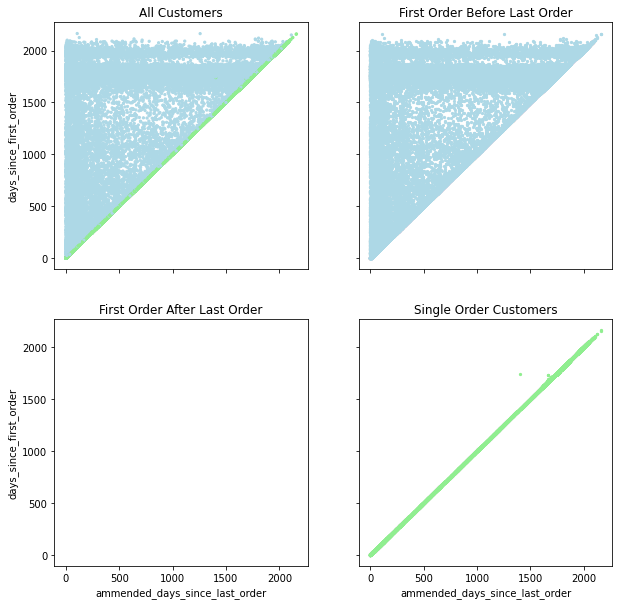

In [9]:
data['ammended_days_since_last_order'] = data['days_since_last_order']/24

fig, axes = plt.subplots(
    nrows=2, ncols=2,
    figsize=(10, 10),
    sharey=True,
    sharex=True
)


first_order_after = [True if x>y else False for x, y in zip(data['ammended_days_since_last_order'], data['days_since_first_order'])]
single_order = [True if x == 1 else False for x in data['orders']]
colors = [single_order_color if x else first_order_after_color if y else first_order_before_color for x, y in zip(single_order, first_order_after)]

# Plot all the points
data.plot.scatter(
    x='ammended_days_since_last_order',
    y='days_since_first_order',
    c=colors,
    marker='.',
    title='All Customers',
    ax=axes[0,0]
)

# Plot single order customers only
single_order = data[data.orders==1]
single_order.plot.scatter(
    x='ammended_days_since_last_order',
    y='days_since_first_order',
    marker='.',
    title="Single Order Customers",
    c=single_order_color,
    ax=axes[1,1])

# Plot customers with last order before first order
first_order_after = data[data['ammended_days_since_last_order'] > data['days_since_first_order']]
first_order_after.plot.scatter(
    x='ammended_days_since_last_order',
    y='days_since_first_order',
    marker='.',
    c=first_order_after_color,
    title="First Order After Last Order",
    ax=axes[1,0])


# Plot customers with last order before first order
first_order_before = data[data['ammended_days_since_last_order'] <= data['days_since_first_order']]
first_order_before.plot.scatter(
    x='ammended_days_since_last_order',
    y='days_since_first_order',
    marker='.',
    c=first_order_before_color,
    title="First Order Before Last Order",
    ax=axes[0,1])

plt.show()

This looks fine now as the `Single Order Customers` are following and `y=x` trajectory!

#### Next, let's compare the columns in the data to the ones reported in the README file

In [10]:
# columns information from assignment's README file
columns_info = pd.read_csv("columns_info.txt")

known_cols = list(columns_info.Column)
actual_cols = list(data.columns)

# columns in known but not in actual
missing = [col for col in known_cols if col not in actual_cols]
new_cols = [col for col in actual_cols if col not in known_cols]

print(f"""
Missing columns: {missing}

New columns: {new_cols}
__""")


Missing columns: []

New columns: ['redpen_discount_used', 'coupon_discount_applied', 'ammended_days_since_last_order']
__


* Three columns here are not mentioned in the assignment's README
  * `redpen_discount_used`
  * `coupon_discount_applied`
  * `ammended_days_since_last_order` (we added this)

#### Let's check the data types and the statistically profile of the columns

In [11]:
profile_df = data.describe(include='all').T
profile_df['sample_value'] = data.head(1).T
profile_df['dtypes'] = data.dtypes
profile_df['nulls'] = data.isna().sum()
profile_df = profile_df[['sample_value', 'dtypes', 'nulls', 'count', 'unique', 'top', 'freq', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']]
profile_df.index.name = 'column_name'

def highlight_relevant_profile_df(x):
    h_color = 'background-color: lightgreen'
    h_cells = {
        'coupon_discount_applied': ['nulls'],
        'customer_id': ['count', 'unique', 'top', 'freq'],
        'is_newsletter_subscriber': ['sample_value', 'dtypes'],
        'days_since_last_order': ['mean','std','min','25%','50%','75%','max']
    }
    if h_cells.get(x.name):
        return [h_color for col in profile_df.columns]
    else:
        return ['' for col in profile_df.columns]

profile_df.style.apply(highlight_relevant_profile_df, axis=1)

,sample_value,dtypes,nulls,count,unique,top,freq,mean,std,min,25%,50%,75%,max
column_name,,,,,,,,,,,,,,
customer_id,64f7d7dd7a59bba7168cc9c960a5c60e,object,0,46279,46030,af9c7c10da2f8f5cf9ac490110c3e48c,2,nan,nan,nan,nan,nan,nan,nan
days_since_first_order,2091,int64,0,46279.000000,nan,nan,nan,1374.041444,604.972862,1.000000,910.000000,1713.000000,1786.000000,2164.000000
days_since_last_order,15672,int64,0,46279.000000,nan,nan,nan,24592.675382,16935.826675,24.000000,6816.000000,25560.000000,41640.000000,51840.000000
is_newsletter_subscriber,N,object,0,46279,2,N,27374,nan,nan,nan,nan,nan,nan,nan
orders,17,int64,0,46279.000000,nan,nan,nan,4.108213,8.115099,1.000000,1.000000,2.000000,4.000000,665.000000
items,50,int64,0,46279.000000,nan,nan,nan,8.575077,19.932067,1.000000,1.000000,3.000000,7.000000,701.000000
cancels,0,int64,0,46279.000000,nan,nan,nan,0.053091,2.169831,0.000000,0.000000,0.000000,0.000000,460.000000
returns,1,int64,0,46279.000000,nan,nan,nan,1.622312,7.006281,0.000000,0.000000,0.000000,1.000000,343.000000
different_addresses,0,int64,0,46279.000000,nan,nan,nan,0.116554,0.320891,0.000000,0.000000,0.000000,0.000000,1.000000


#### Looks like most of the columns are in order in terms of data type, missing values and general distribution. The highlighted cells indicate some interesting insights:

* `customer_id`: There are more counts than unique which indicates the presence of duplicates
* `days_since_last_order:` We have already addressed the issue here that the values were in fact in hours i.e. 24 times too high.
* `is_newsletter_subscriber`: Values are Y/N - we might want to convert to 1/0 or True/False (KIV)
* `coupon_discount_applied`: There are more than 10k missing/null values. Perhaps it should just be filled by 0?
* `male_items` and `female_items`: Are these the sum total of apparrel, footwear, accessories and sportswear (and curvy)?

Let's address the duplication, null value and the sum of items issues!

#### Remove Duplicates

In [12]:
print(f"There are {data[data.duplicated()].shape[0]} duplicated rows")
print(f"There are {data[data.duplicated(subset='customer_id')].shape[0]} duplicated instances of customer_id")

There are 249 duplicated rows
There are 249 duplicated instances of customer_id


That makes it easy as the duplicated instances of customer_id are just duplicated rows and not updates. We can just remove them.

In [13]:
print(f"Original rows: {data.shape[0]}")
data.drop_duplicates(inplace=True, ignore_index=True)
print(f"Remaining rows: {data.shape[0]}")

Original rows: 46279
Remaining rows: 46030


#### Coupon Discount

Let's look at whether 0 already exists

In [14]:
data[data.coupon_discount_applied==0].shape

(19228, 44)

In [15]:
data[data['coupon_discount_applied'].isna()].head(1)

,customer_id,days_since_first_order,days_since_last_order,is_newsletter_subscriber,orders,items,cancels,returns,different_addresses,shipping_addresses,devices,vouchers,cc_payments,paypal_payments,afterpay_payments,apple_payments,female_items,male_items,unisex_items,wapp_items,wftw_items,mapp_items,wacc_items,macc_items,mftw_items,wspt_items,mspt_items,curvy_items,sacc_items,msite_orders,desktop_orders,android_orders,ios_orders,other_device_orders,work_orders,home_orders,parcelpoint_orders,other_collection_orders,redpen_discount_used,coupon_discount_applied,average_discount_onoffer,average_discount_used,revenue,ammended_days_since_last_order
5775,78587f89fb3abe3a0a7d24b8e035c59f,219,5256,N,1,2,0,1,0,1,1,0,1,0,0,0,2,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0.0,NaN,0.0,0.0,272.64,219.0


In [16]:
data[data['coupon_discount_applied']==0].head(1)

,customer_id,days_since_first_order,days_since_last_order,is_newsletter_subscriber,orders,items,cancels,returns,different_addresses,shipping_addresses,devices,vouchers,cc_payments,paypal_payments,afterpay_payments,apple_payments,female_items,male_items,unisex_items,wapp_items,wftw_items,mapp_items,wacc_items,macc_items,mftw_items,wspt_items,mspt_items,curvy_items,sacc_items,msite_orders,desktop_orders,android_orders,ios_orders,other_device_orders,work_orders,home_orders,parcelpoint_orders,other_collection_orders,redpen_discount_used,coupon_discount_applied,average_discount_onoffer,average_discount_used,revenue,ammended_days_since_last_order
1,fa7c64efd5c037ff2abcce571f9c1712,2082,528,Y,13,26,0,5,0,4,2,0,0,1,0,0,24,0,2,16,2,0,4,4,0,3,0,0,0,12,1,0,0,0,0,9,0,4,629.03,0.0,0.1404,1404.0966,5329.28,22.0


Interestingly, there is already 19228 rows where `coupon_discount_applied` is 0. At this point, it would be better to actually check with the data entry team or domain experts whether there is a difference between null and 0. However, for now let's just assume they are the same and set it to 0 as almost a quarter of the rows are null.

In [17]:
data['coupon_discount_applied'] = data['coupon_discount_applied'].fillna(0)

#### Are curvy only female items?

Let's confirm that curvy items are definitely female items!

In [18]:
print(f"No male items but curvy items present: {data[(data['male_items']==0) & (data['curvy_items']>0)].shape}")
print(f"No female items but curvy items presetn: {data[(data['female_items']==0) & (data['curvy_items']>0)].shape}")

No male items but curvy items present: (448, 44)
No female items but curvy items presetn: (0, 44)


The answer is a resounding yes that is curvy items are only for females! (Good gender indication?)

#### Items total

Difference between actual sum of female/male items and female_items/male_items in the data


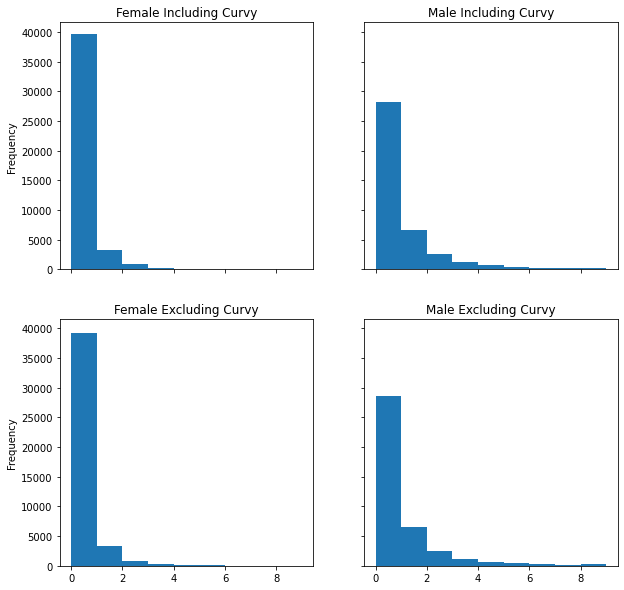

In [19]:
female_items = pd.DataFrame()
female_items['with_curvy'] = data[['wapp_items', 'wftw_items', 'wacc_items', 'wspt_items', 'curvy_items', 'sacc_items']].sum(axis=1)
female_items['without_curvy'] = data[['wapp_items', 'wftw_items', 'wacc_items', 'wspt_items', 'sacc_items']].sum(axis=1)
female_items['female_items'] = data['female_items']
female_items['diff'] = female_items['without_curvy'] - female_items['female_items']

male_items = pd.DataFrame()
male_items['with_curvy'] = data[['mapp_items', 'mftw_items', 'macc_items', 'mspt_items', 'curvy_items', 'sacc_items']].sum(axis=1)
male_items['without_curvy'] = data[['mapp_items', 'mftw_items', 'macc_items', 'mspt_items', 'sacc_items']].sum(axis=1)
male_items['male_items'] = data['male_items']
male_items['diff'] = male_items['without_curvy'] - male_items['male_items']

fig, axes = plt.subplots(
    nrows=2, ncols=2,
    figsize=(10, 10),
    sharey=True,
    sharex=True,
)

(female_items['with_curvy'] - female_items['female_items']).plot.hist(bins=range(10), title='Female Including Curvy', ax=axes[0,0])
(female_items['without_curvy'] - female_items['female_items']).plot.hist(bins=range(10), title='Female Excluding Curvy', ax=axes[1,0])


(male_items['with_curvy'] - male_items['male_items']).plot.hist(bins=range(10), title='Male Including Curvy', ax=axes[0,1])
(male_items['without_curvy'] - male_items['male_items']).plot.hist(bins=range(10), title='Male Excluding Curvy', ax=axes[1,1])
print("Difference between actual sum of female/male items and female_items/male_items in the data")

Interestingly, while most of the items total does match, there are quite a lot especially for males that do not!

# Data Exploration

Let's answer some questions to get a sense of the data! And, we will do so using SQL because why not!

### Q. What was the total revenue to the nearest dollar for customers who have paid by credit card?

In [20]:
revenue = pd.read_sql("Select round(sum(revenue)) from customers where cc_payments=1", connection).iloc[0][0]
print(f"${revenue:,.2f}")

$50,372,282.00


### Q What percentage of customers who have purchased female items have paid by credit card?

First, let's just ensure that the cc_payments values are in line with the data definition of "Number of times a credit card was used for payment"

In [21]:
cc_data = pd.read_sql("SELECT count(*) as count from customers group by cc_payments", connection)
cc_data

,count
0,16550
1,29729


Either people have only made 1 or 0 credit card payments which would be very strange, or this column really just means whether someone has ever used a credit card or not. Let's see whether the same applies to other modes of payment too.

[]

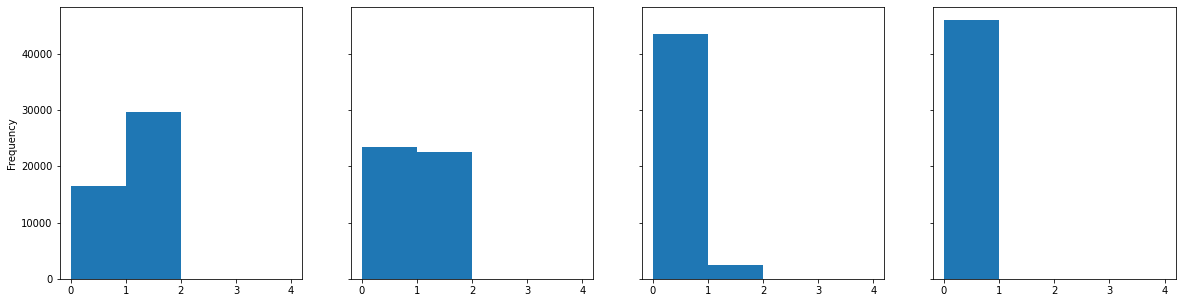

In [22]:
fig, axes = plt.subplots(
    nrows=1, ncols=4,
    figsize=(20, 5),
    sharey=True
)

for i, payment_mode in enumerate(['cc_payments', 'paypal_payments', 'afterpay_payments', 'apple_payments']):
    data[payment_mode].plot.hist(ax=axes[i], bins=range(5))
    
plt.plot()

Seems like the same is also true for other modes of payments. At this point again I would check with the data entry team and domain experts to confirm that indeed these columns do not indicate number of times a mode of payment is used but whether or not a mode of payment has been used!

Anyway, let's get back to answering the question of the percentage of customers who purcahsed female_items used a credit card!

In [23]:
female_cc = pd.read_sql("select count(*) as count from customers where female_items>0 group by cc_payments", connection)
index_names = {0:"Never used credit card", 1:"Used credit card"}
female_cc.index = [index_names[x] for x in female_cc.index]
female_cc

,count
Never used credit card,11935
Used credit card,22588


In [24]:
percentage = female_cc/female_cc.sum() * 100
percentage_cc_only = percentage.loc['Never used credit card'][0]
print(f"Percentage: {percentage_cc_only:.2f}%")

Percentage: 34.57%


### Q. What was the average revenue for customers who used either iOS, Android or Desktop?

In [25]:
average = pd.read_sql("""
SELECT AVG(revenue) 
FROM customers
WHERE desktop_orders>0 OR android_orders>0 OR ios_orders>0""", connection).iloc[0][0]

print(f"${average:,.2f}")

$1,484.89


### Q. We want to run an email campaign promoting a new mens luxury brand. Can you provide a list of customers we should send to?

For this task, we would need to delve a bit deeper into the columns available. I have converted to table provided in the README file into txt file. Let's load it up and see what we have!

In [26]:
columns_info = pd.read_csv('columns_info.txt')

def highlight_relevant(x):
    if x.name in [0, 5, 17, 40]:
        return ['background-color: lightgreen']*3
    else:
        return ['background-color: white']*3

columns_info.style.apply(highlight_relevant, axis=1)

,Column,Value,Description
0,customer_id,string,ID of the customer - super duper hashed
1,days_since_first_order,integer,Days since the first order was made
2,days_since_last_order,integer,Days since the last order was made
3,is_newsletter_subscriber,string,Flag for a newsletter subscriber
4,orders,integer,Number of orders
5,items,integer,Number of items
6,cancels,integer,Number of cancellations - when the order is cancelled after being placed
7,returns,integer,Number of returned orders
8,different_addresses,integer,Number of times a different billing and shipping address was used
9,shipping_addresses,integer,Number of different shipping addresses used


Unfortunately, we do not have any column which specifically relates to men luxury items so we would need to infer that in a crude by getting the average cost of items purchased. Let's try to plot the average revenue per item purchased.

Cummulative distribution of average cost of male items


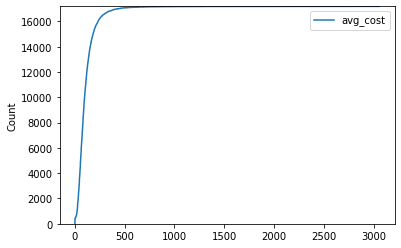

In [27]:
avg_male_item_cost = pd.read_sql_query("""
SELECT customer_id, revenue/items as avg_cost from customers where male_items>0""", connection)

sns.ecdfplot(data=avg_male_item_cost, stat='count')
print("Cummulative distribution of average cost of male items")

In [28]:
top5 = avg_male_item_cost.quantile(0.95).values[0]
print(f"Maybe we can assume the top 5 percent as luxury items. That is anything above {top5:,.2f} is a male luxury item")

Maybe we can assume the top 5 percent as luxury items. That is anything above 258.96 is a male luxury item


In [29]:
luxury_customers = avg_male_item_cost[avg_male_item_cost['avg_cost']>=top5].reset_index(drop=True)
print(f"Number of Customers to Target: {luxury_customers.shape[0]}")
luxury_customers.head()

Number of Customers to Target: 860


,customer_id,avg_cost
0,7ff8e4063a65e668de93d4aa6f688a8e,272.540000
1,821e6c5befb015db862290d2edddbe96,328.314211
2,5dc61ca9e0c9f1237283042aabf87376,306.335263
3,b54e001e1f710ae9fc906f37ae6a68be,540.640000
4,bd2d01a5f8be94b7161770ff4ca0d6b0,380.832941


# Engineer Some Features

* `days_per_order` is better than just orders or days to normalize records for new, old and lost customers
* `items_per_order` is a good indication of spending behavior

In [30]:
data['days_per_order'] = (data['days_since_first_order'] - data['days_since_last_order']) / data['orders']
data['items_per_order'] = data['items'] / data['orders']

# Build a Model to Predict Gender!

Since we have no labels in the dataset, we need to improvise a little bit. The plan is the following:

1. Create a labelled dataset from a subset of the original data which has some attribtes indicating the gender quite clearly.
1. Split that subset into train and test.
1. Train a model which uses attributes other than those that are quite obvious so that it generalizes on broader behavior trends.
1. Assess it against the test labelled dataset.

Let's be conservative initially and classify `surely_male` as those who have never bought female items and have bought more than 2 male_items. The reverse is true for `surely_female`!

In [31]:
surely_male = data[(data['male_items']>2) & (data[['wapp_items', 'wftw_items', 'wacc_items', 'wspt_items', 'curvy_items']].sum(axis=1)==0)].copy()
surely_male.shape

(3676, 46)

In [32]:
surely_female = data[(data[['mapp_items', 'mftw_items', 'macc_items', 'mspt_items']].sum(axis=1)==0) & (data['female_items']>2)].copy()
surely_female.shape

(8324, 46)

Sweet, we have a decent sized though unbalanced data set. Let's use these to train a good model!

In [33]:
surely_male['gender'] = 0
surely_female['gender'] = 1
sure_genders = pd.concat([surely_female, surely_male], ignore_index=True)
sure_genders['sample_weight'] = [surely_female.shape[0] if x==0 else surely_male.shape[0] for x in sure_genders['gender']]
sure_genders['sample_weight'] = sure_genders['sample_weight']/sure_genders.shape[0]
sure_genders.head()

,customer_id,days_since_first_order,days_since_last_order,is_newsletter_subscriber,orders,items,cancels,returns,different_addresses,shipping_addresses,devices,vouchers,cc_payments,paypal_payments,afterpay_payments,apple_payments,female_items,male_items,unisex_items,wapp_items,wftw_items,mapp_items,wacc_items,macc_items,mftw_items,wspt_items,mspt_items,curvy_items,sacc_items,msite_orders,desktop_orders,android_orders,ios_orders,other_device_orders,work_orders,home_orders,parcelpoint_orders,other_collection_orders,redpen_discount_used,coupon_discount_applied,average_discount_onoffer,average_discount_used,revenue,ammended_days_since_last_order,days_per_order,items_per_order,gender,sample_weight
0,dbb68f4e15ec99e0657c7ebb0cd02249,2023,48336,N,2,4,1,0,0,1,1,1,1,1,0,0,4,0,0,3,1,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,2,0.00,27.21,0.0000,1668.3017,119.58,2014.0,-23156.500000,2.000000,1,0.306333
1,2a6dfcbc444a9b55050fe1d77c5c8cd0,2043,528,Y,7,13,1,0,0,1,2,0,1,1,0,0,13,0,0,6,7,0,0,0,0,0,0,0,0,2,5,0,0,0,0,2,0,5,970.41,0.00,0.2905,2904.8457,1976.13,22.0,216.428571,1.857143,1,0.306333
2,32289eb09797c7507868f86621876e05,2037,36096,Y,3,3,0,1,0,2,1,1,1,1,0,0,3,0,0,1,2,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,3,49.97,18.18,0.1666,2555.9759,172.61,1504.0,-11353.000000,1.000000,1,0.306333
3,35c1cec0fca55772fb0dfe69339776ca,2015,44304,N,3,5,0,0,0,1,1,3,1,0,0,0,3,1,1,2,1,0,0,0,0,1,0,0,0,0,3,0,0,0,0,0,0,3,160.00,540.00,0.0889,8024.4751,149.75,1846.0,-14096.333333,1.666667,1,0.306333
4,77838a9756e48f120e619f66d30eab83,2028,42240,N,3,11,0,4,0,2,1,0,1,0,0,0,11,0,0,8,3,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,3,647.25,0.00,0.1078,1078.4147,3019.37,1760.0,-13404.000000,3.666667,1,0.306333


Let's see what correlations are there with gender!

In [34]:
sure_genders.corr()[['gender']].sort_values('gender')

,gender
sample_weight,-1.000000
male_items,-0.575127
mftw_items,-0.518804
mapp_items,-0.482357
mspt_items,-0.286849
unisex_items,-0.171767
items_per_order,-0.114254
ammended_days_since_last_order,-0.092434
days_since_last_order,-0.092434
sacc_items,-0.075856


Interestingly, the `macc_items` and `wacc_items` are both showing NaN which indicates they are all 0. This means that when we exclude customers who have never bought male only items we also excluded those who bought women's accessories (and vice versa). Let's confirm that!

In [35]:
print(data[(data['wacc_items']==0) & (data['macc_items']>0)].shape)
print(data[(data['macc_items']==0) & (data['wacc_items']>0)].shape)

(0, 46)
(0, 46)


Indeed, there are no customers who have bought only women accessories OR only men accessories!

Anyway, looking at the data, we have quit a few features that are weakly correlated to gender in our dataset. Let's exclude the male and female accessories columns and only focus on behavior and see if we get a good model.

In [36]:
from sklearn.model_selection import train_test_split

train, eval_test = train_test_split(sure_genders, test_size=0.3, random_state=786)
evaluation, test = train_test_split(eval_test, test_size=0.3, random_state=786)

print("Train set gender distribution", train.groupby('gender').count()['customer_id']/train.shape[0])
print("Test set gender distribution", evaluation.groupby('gender').count()['customer_id']/evaluation.shape[0])
print("Train set gender distribution", test.groupby('gender').count()['customer_id']/test.shape[0])

Train set gender distribution gender
0    0.306548
1    0.693452
Name: customer_id, dtype: float64
Test set gender distribution gender
0    0.305952
1    0.694048
Name: customer_id, dtype: float64
Train set gender distribution gender
0    0.305556
1    0.694444
Name: customer_id, dtype: float64


Both sets have similar distribution, let's filter the features to use!

In [37]:
from catboost import CatBoostClassifier

features = [
    'wapp_items', 'wftw_items', 'wacc_items', 'wspt_items', 'curvy_items',
    'mapp_items', 'mftw_items', 'macc_items', 'mspt_items', 'days_since_first_order',
    'is_newsletter_subscriber', 'days_per_order', 'items_per_order', 'cancels', 'returns',
    'different_addresses', 'shipping_addresses', 'devices', 'vouchers',
    'cc_payments', 'paypal_payments', 'afterpay_payments', 'apple_payments',
    'sacc_items', 'msite_orders',
    'desktop_orders', 'android_orders', 'ios_orders', 'other_device_orders',
    'work_orders', 'home_orders', 'parcelpoint_orders',
    'other_collection_orders', 'redpen_discount_used',
    'coupon_discount_applied', 'average_discount_onoffer',
    'average_discount_used', 'revenue', 'ammended_days_since_last_order',]

# use the vanilla flavor
cb = CatBoostClassifier()

cb.fit(
    train[features],
    y=train['gender'],
    cat_features=['is_newsletter_subscriber', 'cc_payments', 'paypal_payments', 'afterpay_payments', 'apple_payments'], 
    sample_weight=train['sample_weight'],
    eval_set=(evaluation[features], evaluation['gender']),
    verbose=25
)

Learning rate set to 0.053605
0:	learn: 0.5891398	test: 0.6044903	best: 0.6044903 (0)	total: 64.2ms	remaining: 1m 4s
25:	learn: 0.0423687	test: 0.0421841	best: 0.0421841 (25)	total: 170ms	remaining: 6.38s
50:	learn: 0.0305524	test: 0.0339262	best: 0.0339063 (49)	total: 266ms	remaining: 4.96s
75:	learn: 0.0273126	test: 0.0327967	best: 0.0327967 (75)	total: 373ms	remaining: 4.54s
100:	learn: 0.0245269	test: 0.0328735	best: 0.0325456 (80)	total: 482ms	remaining: 4.29s
125:	learn: 0.0224532	test: 0.0331559	best: 0.0325456 (80)	total: 583ms	remaining: 4.04s
150:	learn: 0.0206612	test: 0.0333198	best: 0.0325456 (80)	total: 679ms	remaining: 3.81s
175:	learn: 0.0191349	test: 0.0334127	best: 0.0325456 (80)	total: 774ms	remaining: 3.62s
200:	learn: 0.0177724	test: 0.0336059	best: 0.0325456 (80)	total: 876ms	remaining: 3.48s
225:	learn: 0.0167209	test: 0.0340944	best: 0.0325456 (80)	total: 975ms	remaining: 3.34s
250:	learn: 0.0160817	test: 0.0344378	best: 0.0325456 (80)	total: 1.07s	remaining: 3.

In [38]:
from sklearn.metrics import confusion_matrix, accuracy_score

test['predictions'] = cb.predict(test[features])

print(f"Accuracy: {accuracy_score(test['gender'], test['predictions']):,.5f}")

pd.DataFrame(confusion_matrix(test['gender'], test['predictions']))

Accuracy: 0.97963


<ipython-input-38-475a78073117>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predictions'] = cb.predict(test[features])


,0,1
0,330,0
1,22,728


Now let's use this model to predict on unlabelled data and get the probabilities!

In [39]:
unsure_gender = data[~data['customer_id'].isin(sure_genders['customer_id'])].copy()
unsure_gender.shape

(34056, 46)

<AxesSubplot:title={'center':'Probability of Male'}, ylabel='Frequency'>

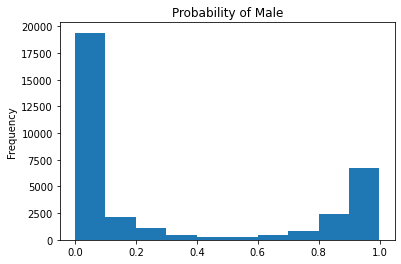

In [40]:
unsure_gender['proba'] = [x[0] for x in cb.predict_proba(unsure_gender[features])]
unsure_gender['proba'].plot.hist(title='Probability of Male')

Interestingly, even without seeing this data the model is quite sure of most of the customers being male or female.

Let's see how many of the records have certainty above 90%.

In [41]:
threshold = 0.90
high_certainty = unsure_gender[(unsure_gender['proba'] > threshold) | (unsure_gender['proba'] < 1-threshold)]

print(f"{high_certainty.shape[0]} out of {unsure_gender.shape[0]} records are high certainty i.e. above {threshold} probability")

26091 out of 34056 records are high certainty i.e. above 0.9 probability


This model might alrady be satisfactory, but to give the model a further push, we can add these high certainty predictions into our labelled data as well. This might allow the model to generalize a bit better as previously the training data had the most obvious of gender clusters!

In [42]:
high_certainty['gender'] = round(high_certainty['proba'])
high_certainty.groupby('gender').count()['customer_id']

<ipython-input-42-b87ceec900c5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_certainty['gender'] = round(high_certainty['proba'])


gender
0.0    19389
1.0     6702
Name: customer_id, dtype: int64

What is interesting here is that we have many more Men (0) then Women (1) which was not the case in the original smaller dataset. In an actual scenario, I would try out this technique on an actual labelled data set to verify that it works. For now lets continue to be adventurous!

In [43]:
columns = features + ['gender']
larger_dataset = pd.concat([sure_genders[columns], high_certainty[columns]], ignore_index=True)
gender_ratios = larger_dataset.groupby('gender').count().iloc[:,1]
gender_ratios

gender
0.0    23065
1.0    15026
Name: wftw_items, dtype: int64

We have a decent but slight unbalanced dataset this time. We can skip sample_weightage. Let's add sample weights

In [44]:
larger_dataset['sample_weight'] = [gender_ratios.iloc[int(gender)] for gender in larger_dataset['gender']]
larger_dataset['sample_weight'] = larger_dataset['sample_weight'] / larger_dataset.shape[0]
larger_dataset.tail()

,wapp_items,wftw_items,wacc_items,wspt_items,curvy_items,mapp_items,mftw_items,macc_items,mspt_items,days_since_first_order,is_newsletter_subscriber,days_per_order,items_per_order,cancels,returns,different_addresses,shipping_addresses,devices,vouchers,cc_payments,paypal_payments,afterpay_payments,apple_payments,sacc_items,msite_orders,desktop_orders,android_orders,ios_orders,other_device_orders,work_orders,home_orders,parcelpoint_orders,other_collection_orders,redpen_discount_used,coupon_discount_applied,average_discount_onoffer,average_discount_used,revenue,ammended_days_since_last_order,gender,sample_weight
38086,0,0,0,0,0,0,1,0,0,73,N,-1679.000000,1.000000,0,0,0,1,1,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0.00,23.63,0.0000,1999.4923,94.55,73.0,1.0,0.394476
38087,54,5,1,1,0,0,5,1,0,1045,Y,-41.966667,2.233333,0,54,0,2,2,15,1,1,0,0,1,11,0,0,19,0,0,22,0,8,3180.15,1390.32,0.2368,3296.5915,9263.71,96.0,0.0,0.605524
38088,17,7,8,4,0,1,0,8,0,1372,N,9.555556,2.222222,0,0,0,7,2,5,1,1,0,0,0,1,11,0,6,0,0,15,0,3,141.96,1791.33,0.0091,3525.6721,3822.84,50.0,0.0,0.605524
38089,2,0,0,0,0,0,0,0,0,1308,N,-11322.000000,1.000000,0,0,1,2,1,0,1,0,0,0,0,0,2,0,0,0,0,0,0,2,150.00,0.00,0.1500,1500.0000,521.81,998.0,0.0,0.605524
38090,3,4,0,1,0,1,0,0,2,673,Y,-335.833333,1.833333,0,0,0,1,2,0,1,0,0,0,0,5,1,0,0,0,0,6,0,0,107.28,0.00,0.1001,1000.5761,964.05,112.0,0.0,0.605524


In [45]:
from sklearn.model_selection import train_test_split

train2, eval_test2 = train_test_split(larger_dataset, test_size=0.3, random_state=786)
evaluation2, test2 = train_test_split(eval_test2, test_size=0.3, random_state=786)
print("Train set gender distribution", train2.groupby('gender').count().iloc[:,1]/train2.shape[0])
print("Test set gender distribution", evaluation2.groupby('gender').count().iloc[:,1]/evaluation2.shape[0])
print("Train set gender distribution", test2.groupby('gender').count().iloc[:,1]/test2.shape[0])

Train set gender distribution gender
0.0    0.604096
1.0    0.395904
Name: wftw_items, dtype: float64
Test set gender distribution gender
0.0    0.611326
1.0    0.388674
Name: wftw_items, dtype: float64
Train set gender distribution gender
0.0    0.603091
1.0    0.396909
Name: wftw_items, dtype: float64


In [46]:
# use the vanilla flavor
cb2 = CatBoostClassifier()

cb2.fit(
    train2[features],
    y=train2['gender'],
    cat_features=['is_newsletter_subscriber', 'cc_payments', 'paypal_payments', 'afterpay_payments', 'apple_payments'], 
    sample_weight=train2['sample_weight'],
    eval_set=(evaluation2[features], evaluation2['gender']),
    verbose=25
)

Learning rate set to 0.071303
0:	learn: 0.6086810	test: 0.6136248	best: 0.6136248 (0)	total: 14.2ms	remaining: 14.2s
25:	learn: 0.1649475	test: 0.1878670	best: 0.1878670 (25)	total: 300ms	remaining: 11.2s
50:	learn: 0.1085497	test: 0.1280803	best: 0.1280803 (50)	total: 550ms	remaining: 10.2s
75:	learn: 0.0818059	test: 0.0999277	best: 0.0999277 (75)	total: 782ms	remaining: 9.5s
100:	learn: 0.0720781	test: 0.0905610	best: 0.0905610 (100)	total: 1s	remaining: 8.9s
125:	learn: 0.0667189	test: 0.0865437	best: 0.0865437 (125)	total: 1.22s	remaining: 8.47s
150:	learn: 0.0619513	test: 0.0826958	best: 0.0826958 (150)	total: 1.45s	remaining: 8.16s
175:	learn: 0.0593826	test: 0.0813350	best: 0.0813350 (175)	total: 1.67s	remaining: 7.81s
200:	learn: 0.0563366	test: 0.0788356	best: 0.0788356 (200)	total: 1.89s	remaining: 7.52s
225:	learn: 0.0535786	test: 0.0773916	best: 0.0773916 (225)	total: 2.12s	remaining: 7.25s
250:	learn: 0.0513562	test: 0.0763688	best: 0.0763503 (249)	total: 2.36s	remaining: 

In [47]:
from sklearn.metrics import confusion_matrix, accuracy_score

test2['predictions'] = cb2.predict(test2[features])

print(f"Accuracy: {accuracy_score(test2['gender'], test2['predictions']):,.5f}")

pd.DataFrame(confusion_matrix(test2['gender'], test2['predictions']))

Accuracy: 0.97609


<ipython-input-47-496bd5b78dab>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test2['predictions'] = cb2.predict(test2[features])


,0,1
0,2036,32
1,50,1311


This is reasonably good! Of course, if we had the labels we could have tried to experiment further with other models, feature vectors or hyperparameters. At this stage let's settle for this! 

## What Other Features would have been great to have?

* Browsing history in terms of which categories of items were most frequently visited and clicked
* Number of visits on the app or website - gender may influence the amount of time one spends shopping and window shopping
* More granular details on products purchased would surely help
* Sizes of items ordered - This would be useful to differentiate between parents purchasing kids items so that the genders of those do not interfere with the gender classification of the customer itself!
